# Diffusion models for denoising radar clutter

### Imports

In [4]:
import os
import torch
import wandb
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, ConcatDataset

### wandb initialization

In [5]:
os.environ["WANDB_NOTEBOOK_NAME"] = "iqdif.ipynb"
wandb.login(key="a0b9279da3b2e8d45e371d1539a1118e7b82d303")
wandb.init(project="Radar_Diffusion", mode="online")

wandb: Currently logged in as: ari-granevich. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/arigranevich/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


## Dataset Creation

In [6]:
class RadarDataset(Dataset):
    def __init__(self, num_samples, n_targets: int = 8, random_n_targets=True, nu=None, scnr=None):
        super().__init__()
        self.num_samples = num_samples
        self.n_targets = n_targets
        self.random_n_targets = random_n_targets
        self.with_targets = n_targets > 0
        self.scnr = scnr
        self.nu = torch.tensor([nu]) if nu is not None else None

        # Parameters
        self.N = 64  # Samples per pulse (fast-time)
        self.K = 64  # Pulses per frame (slow-time)
        self.B = 50e6  # Chirp bandwidth (Hz)
        self.T0 = 1e-3  # PRI (s)
        self.fc = 9.39e9  # Carrier frequency (Hz)
        self.c = 3e8  # Speed of light (m/s)
        self.CNR = 15  # Clutter-to-noise ratio (dB)

        # Range and Doppler parameters
        self.r_min, self.r_max = 0, 189  # Range interval (m)
        self.v_min, self.v_max = -7.8, 7.8  # Doppler interval (m/s)
        self.vc_min, self.vc_max = -7.8, 7.8  # Clutter min/max velocity (m/s)
        self.dr = 3  # Range resolution (m)
        self.dv = 0.249  # Doppler resolution (m/s)

        # Calculate range and Doppler bins
        self.R = torch.arange(self.r_min, self.r_max + self.dr, self.dr)
        self.V = torch.arange(self.v_min, self.v_max + self.dv, self.dv)
        self.dR = len(self.R)  # Number of range bins
        self.dV = len(self.V)  # Number of Doppler bins

        # Noise power calculation
        self.sigma2 = self.N / (2 * 10 ** (self.CNR / 10)) 
        self.cn_norm = torch.sqrt(torch.tensor(self.N * self.K * (self.N // 2 + self.sigma2)))

        # Precompute the range steering matrix for matched filtering.
        # This acts as the matched filter in the range dimension.
        # For a linear FM chirp, the matched filter corresponds to the conjugate of the transmitted signal.
        # Here, we assume a uniform linear frequency modulation and use a steering vector based on the range bins.
        # range_steering_full will have dimensions (dR x N).
        w_range = (2 * torch.pi * (2 * self.B) / (self.c * self.N)) * self.R.unsqueeze(-1) * torch.arange(self.N)
        # w_range: dR x N
        self.range_steering_full = torch.exp(-1j * w_range)

    def generate_target_signal(self, ranges, velocities, phases, SCNR_dBs):
        # Range steering vector
        w_r = (2 * torch.pi * 2 * self.B * ranges) / (self.c * self.N)
        range_steering = torch.exp(-1j * torch.outer(w_r, torch.arange(self.N)))

        # Doppler steering vector
        w_d = (2 * torch.pi * self.T0 * 2 * self.fc * velocities) / self.c
        doppler_steering = torch.exp(-1j * torch.outer(w_d, torch.arange(self.K)))
        
        # Fast-time x Slow-time matrix
        rd_signal = range_steering.unsqueeze(-1) * doppler_steering.unsqueeze(1)

        # Random phase for each target
        rd_signal = rd_signal * torch.exp(1j * phases)

        # Scaling SCNR for each target
        S_norm = torch.linalg.norm(rd_signal, dim=(1, 2)).real
        sig_amp = (10 ** (SCNR_dBs / 20)) * (self.cn_norm / S_norm)
        rd_signal = (sig_amp.unsqueeze(-1).unsqueeze(-1) * rd_signal).sum(dim=0)

        return rd_signal

    def generate_clutter(self, nu):
        clutter_vel = torch.empty(1).uniform_(self.vc_min, self.vc_max)
        fd = (2 * torch.pi * (2 * self.fc * clutter_vel) / self.c) 
        sigma_f = 0.05  # From the referenced paper
        p, q = torch.meshgrid(torch.arange(self.N),
                              torch.arange(self.K), indexing='ij')
        M = torch.exp(-2 * torch.pi ** 2 * sigma_f ** 2 * (p - q) ** 2 - 1j * (p - q) * fd * self.T0)
        z = torch.randn(self.K, self.dR, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0))

        e, V = torch.linalg.eigh(M)
        e_sqrt = torch.sqrt(torch.maximum(e.real, torch.tensor(0.0)))
        E = torch.diag(e_sqrt)
        A = V @ E.to(V.dtype)
        w_t = A @ z

        s = torch.distributions.Gamma(nu, nu).sample((self.dR,))
        c_t = (torch.sqrt(s).unsqueeze(0) * w_t.unsqueeze(-1)).squeeze(-1)

        # Convert to fast-time × slow-time representation
        c_r_steer = torch.exp(-1j * 2 * torch.pi * torch.outer(torch.arange(self.N), self.R) * (2 * self.B) / (self.c * self.N))
        C = c_r_steer @ c_t.transpose(0, 1)
        return C

    def gen_frame_and_labels(self):
        # Generate Noise
        W = (torch.randn(self.N, self.K, dtype=torch.cfloat) / torch.sqrt(torch.tensor(2.0 * self.sigma2)))

        # Generate Clutter
        nu = torch.empty(1).uniform_(0.1, 1.5) if self.nu is None else self.nu
        C = self.generate_clutter(nu)

        # Initialize target signal and label matrices
        S = torch.zeros_like(W)
        rd_label = torch.zeros(self.dR, self.dV)
        if self.with_targets:
            n = torch.randint(1, self.n_targets + 1, (1,)) if self.random_n_targets else self.n_targets
            ranges = torch.empty(n).uniform_(self.r_min, self.r_max)
            velocities = torch.empty(n).uniform_(self.v_min, self.v_max)
            phases = torch.empty(n, 1, 1).uniform_(0, 2 * torch.pi)
            SCNR_dBs = torch.empty(n).uniform_(-5, 10) if self.scnr is None else self.scnr * torch.ones(n)
            S = self.generate_target_signal(ranges, velocities, phases, SCNR_dBs)

            # Create label matrix
            for r, v in zip(ranges, velocities):
                r_bin = torch.argmin(torch.abs(self.R - r))
                v_bin = torch.argmin(torch.abs(self.V - v))
                rd_label[r_bin, v_bin] = 1

        return S, C, W, rd_label

    def __len__(self) -> int:
        return self.num_samples

    def __getitem__(self, idx: int):
        S, C, W, rd_label = self.gen_frame_and_labels()
        X = S+C+W
        IQ_map = X
        X_range = self.range_steering_full.conj() @ X     
        S_range = self.range_steering_full.conj() @ S

        S_RD = torch.fft.fft(S_range, dim=1)
        S_RD = torch.fft.fftshift(S_RD, dim=1)
        S_RD_magnitude = S_RD#.abs()
        clean_RD_map = S_RD_magnitude.flip(dims=[1])

        X_RD = torch.fft.fft(X_range, dim=1)
        X_RD = torch.fft.fftshift(X_RD, dim=1)

        X_RD_magnitude = X_RD#.abs()
        RD_map = X_RD_magnitude.flip(dims=[1]) 
        return S, C, IQ_map, clean_RD_map, RD_map, rd_label

In [7]:
# Create datasets with and without targets
train_dataset_with_targets = RadarDataset(num_samples=10240, n_targets=8, random_n_targets=True)
train_dataset_no_targets = RadarDataset(num_samples=10240, n_targets=0)

val_dataset_with_targets = RadarDataset(num_samples=2048, n_targets=8, random_n_targets=True)
val_dataset_no_targets = RadarDataset(num_samples=2048, n_targets=0)

# Combine datasets
train_dataset = ConcatDataset([train_dataset_with_targets, train_dataset_no_targets])
val_dataset = ConcatDataset([val_dataset_with_targets, val_dataset_no_targets])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2,
                            pin_memory=torch.cuda.is_available(), persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2,
                        pin_memory=torch.cuda.is_available(), persistent_workers=True)

IQ_map type: torch.ComplexFloatTensor
RD_map type: torch.ComplexFloatTensor
Slow time x Fast time map shape: torch.Size([64, 64])
Range-Doppler map shape: torch.Size([64, 64])
Label shape: torch.Size([64, 64])


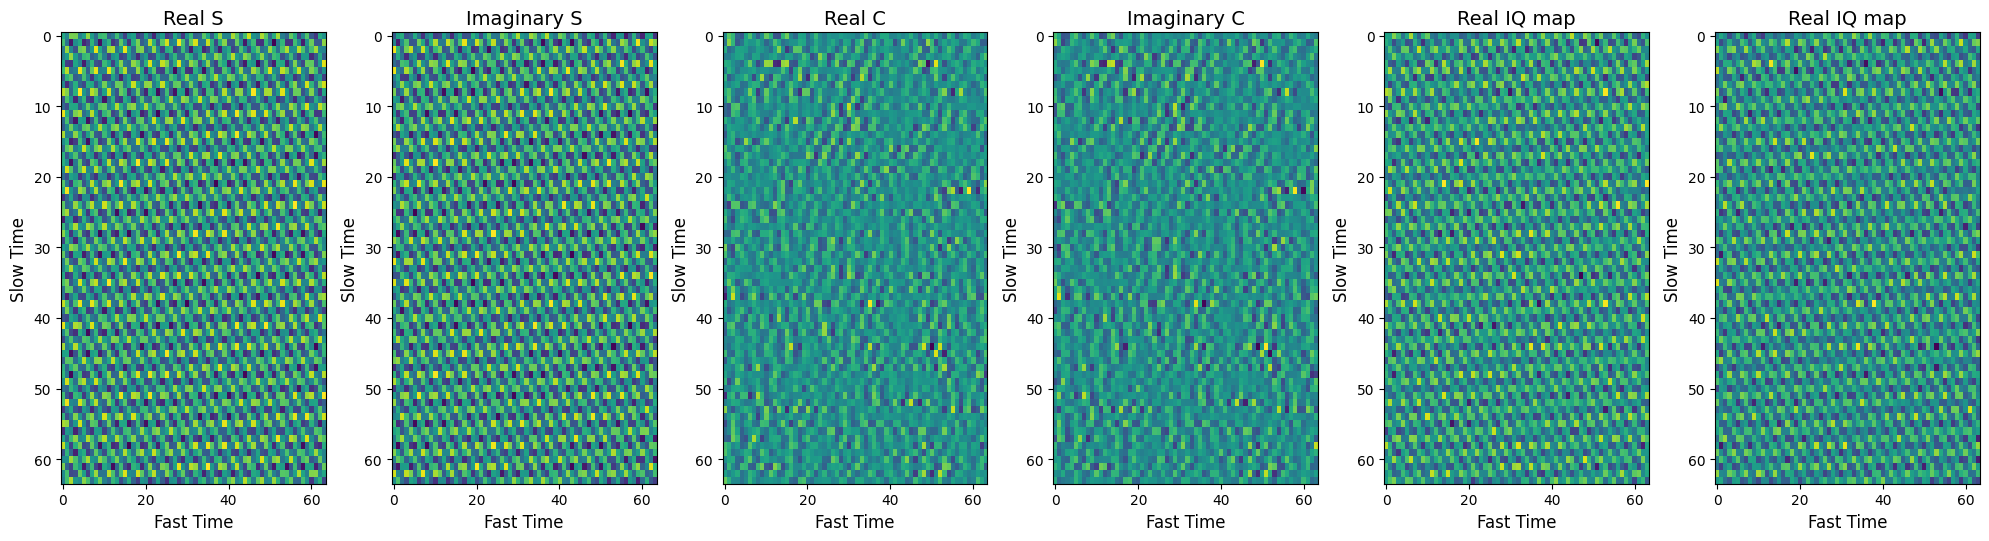

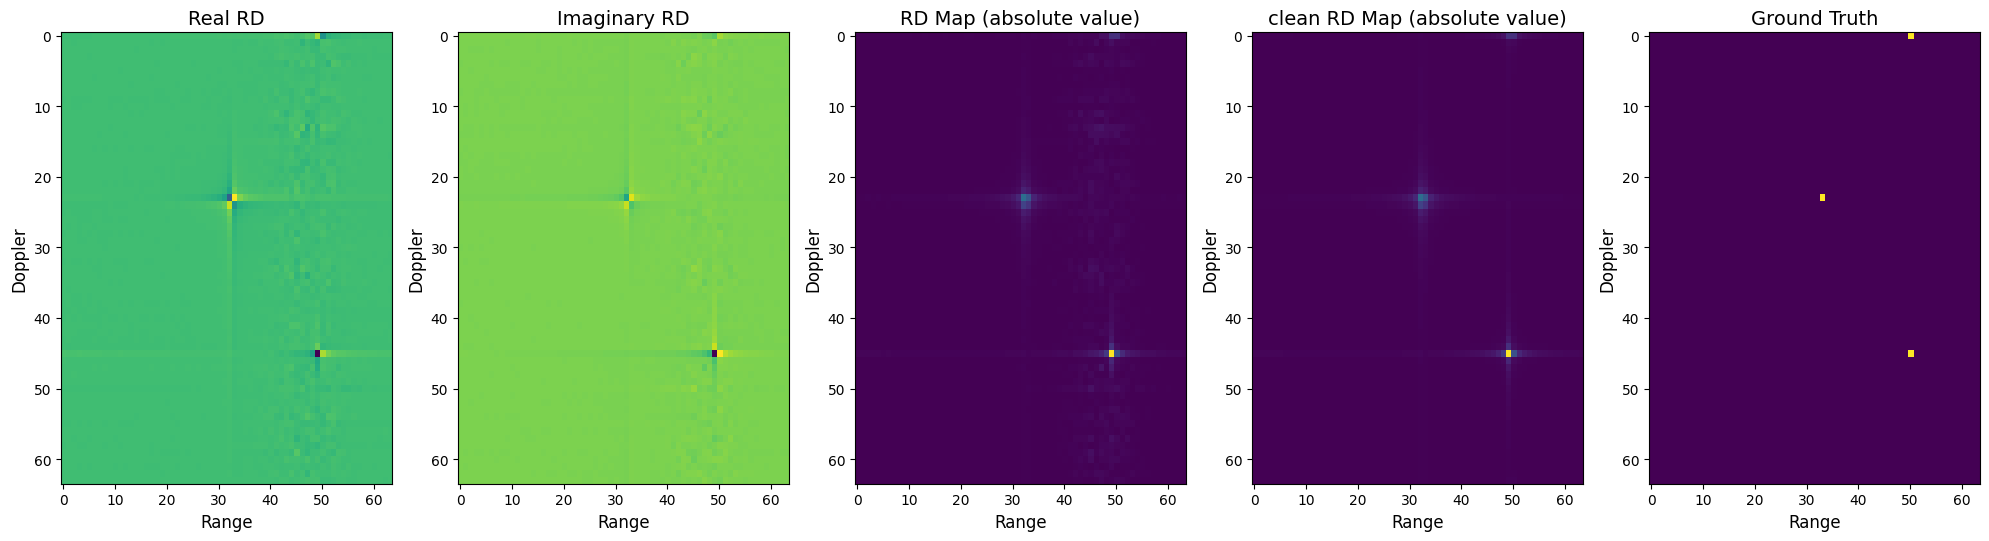

In [8]:
S, C, IQ_map, clean_RD_map, RD_map, RD_label = train_dataset_with_targets[1]

# Print some debug/reference information
print(f"IQ_map type: {IQ_map.type()}")
print(f"RD_map type: {RD_map.type()}")
print(f"Slow time x Fast time map shape: {IQ_map.shape}")
print(f"Range-Doppler map shape: {RD_map.shape}")
print(f"Label shape: {RD_label.shape}")

# Create a figure with five subplots in one row
plt.figure(figsize=(20, 6))

# Subplot 1: Real part of IQ data
plt.subplot(1, 6, 1)
plt.imshow(torch.real(S), aspect='auto', cmap='viridis')
plt.title("Real S", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 2: Imaginary part of IQ data
plt.subplot(1, 6, 2)
plt.imshow(torch.imag(S), aspect='auto', cmap='viridis')
plt.title("Imaginary S", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)
# Subplot 3: Magnitude of X_range
plt.subplot(1, 6, 3)
plt.imshow(torch.real(C) , aspect='auto', cmap='viridis')
plt.title("Real C", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 4: Magnitude of the Range-Doppler map
plt.subplot(1, 6, 4)
plt.imshow(torch.imag(C), aspect='auto', cmap='viridis')
plt.title("Imaginary C", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Subplot 5: Range-Doppler label (ground truth)
plt.subplot(1, 6, 5)
plt.imshow(torch.real(IQ_map), aspect='auto', cmap='viridis')
plt.title("Real IQ map", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

plt.subplot(1, 6, 6)
plt.imshow(torch.imag(IQ_map), aspect='auto', cmap='viridis')
plt.title("Real IQ map", fontsize=14)
plt.xlabel("Fast Time", fontsize=12)
plt.ylabel("Slow Time", fontsize=12)

# Adjust the layout, save, and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("maps")
plt.show()

plt.figure(figsize=(20, 6))

# Subplot 1: Real part of IQ data
plt.subplot(1, 5, 1)
plt.imshow(torch.real(RD_map), aspect='auto', cmap='viridis')
plt.title("Real RD", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Subplot 1: Real part of IQ data
plt.subplot(1, 5, 2)
plt.imshow(torch.imag(RD_map), aspect='auto', cmap='viridis')
plt.title("Imaginary RD", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1, 5, 3)
plt.imshow(torch.abs(RD_map), aspect='auto', cmap='viridis')
plt.title("RD Map (absolute value)", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

plt.subplot(1, 5, 4)
plt.imshow(torch.abs(clean_RD_map), aspect='auto', cmap='viridis')
plt.title("clean RD Map (absolute value)", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Subplot 2: Imaginary part of IQ data
plt.subplot(1, 5, 5)
plt.imshow(RD_label, aspect='auto', cmap='viridis')
plt.title("Ground Truth", fontsize=14)
plt.xlabel("Range", fontsize=12)
plt.ylabel("Doppler", fontsize=12)

# Adjust the layout, save, and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("maps")
plt.show()

## Diffusion model

### Forward Process

The forward process gradually transforms the image into a Normal Distribution by introducing noise over T time steps.
We add the noise gradually according to the below Gaussian Distribution. The noise is controlled by the parameter $\beta _t$
$$ q(x_t | x_{t-1}) = \mathcal{N} \left(x_t ; \sqrt{(1-\beta_t)}x_{t-1}, \beta_t I \right) ; \beta_t < 1$$

Here, we will first try to implement the original 1000 step, where $\beta_1 =10^{-4}$ and  $\beta_T = 0.02$ . Also, $\beta$ is linearly schedueld.

If given input image $x_0$ and $\beta_t$'s, we can precompute all $x_t$'s at once.
$$q(x_t | x_{0}) = \mathcal{N} \left(x_t ; \sqrt{\bar \alpha_t}x_{0}, (1-\bar \alpha_t) I \right)$$
where:
$$\alpha_t = 1-\beta_t$$
$$ \bar \alpha_t = \prod_{s=1}^{t} \alpha_s

In [12]:
class DiffusionForwardProcess:    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)
        
    def add_noise(self, original, noise, t):
        
        """ 
        Adds noise to a batch of original images at time-step t.     
        """
        
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]
        
        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]
        
        # Return
        return (sqrt_alpha_bar_t * original) + (sqrt_one_minus_alpha_bar_t * noise)

Pay attention! the add noise function returns $x_t$ according to its formula: $$x_t =  \sqrt{\bar \alpha_t}x_0 +  \sqrt{1- \bar \alpha_t}\epsilon$$

#### Test shape:

In [29]:
# Test
original = torch.randn(4, 1, 28, 28)
noise = torch.randn(4, 1, 28, 28)
t_steps = torch.randint(0, 1000, (4,)) 
print(original.shape, noise.shape, t_steps.shape)
# Forward Process
dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

torch.Size([4, 1, 28, 28]) torch.Size([4, 1, 28, 28]) torch.Size([4])


torch.Size([4, 1, 28, 28])

### Backward Process

The reverse process is the inverse of the forward process.

The Goal of the reverse process is to gradually denoise the noisy image $x_T$ ~ $\mathcal N (0, 1)$ in T time steps.
$$ x_{t-1} = \frac{1}{\sqrt{\bar \alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar \alpha_t}} \epsilon_{\theta} \right) + \sigma_t z $$
The noise $\epsilon_{\theta}$ is predicted by the model and $z$~$ \mathcal N (0,I)$.

At each time-step, the original image $x_0$ can be predicted using:
$$ x_{0} = \frac{1}{\sqrt{\bar \alpha_t}} \left( x_t - \sqrt{1-\bar \alpha_t} \epsilon_{\theta} \right)$$


In [15]:
class DiffusionReverseProcess:
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        self.b = torch.linspace(beta_start, beta_end, num_time_steps) # b -> beta
        self.a = 1 - self.b # a -> alpha
        self.a_bar = torch.cumprod(self.a, dim=0) # a_bar = alpha_bar
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        
        """ 
        Sample x_(t-1) given x_t and noise predicted by model.
        """
        
        # Original Image Prediction at timestep t
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.) 
        
        # mean of x_(t-1)
        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean/(torch.sqrt(self.a.to(xt.device)[t]))
        
        # only return mean
        if t == 0:
            return mean, x0
        
        else:
            variance =  (1 - self.a_bar.to(xt.device)[t-1])/(1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            return mean + sigma * z, x0

The variance is:
$$ \sigma^2 =  \frac{1-\bar \alpha_{t-1}}{1-\bar \alpha_t} \beta_t $$


#### test shape

In [16]:
# Test
original = torch.randn(1, 1, 28, 28)
noise_pred = torch.randn(1, 1, 28, 28)
t = torch.randint(0, 1000, (1,)) 

# Forward Process
drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

torch.Size([1, 1, 28, 28])

### Model Architecture

#### 1. Time embedding

U-Net is used to predict the noise $\epsilon_{\theta}$ in the noisy image $x_t$. 

The architecture takes two inputs:
* Noisy Image $x_t$: The partially noisy version of the original image.

* Time-step $t$: The current time step in the diffusion process.

The output is the predicted noise, which helps calculate $x_{t−1}$ (the denoised version) and $x_0$ (the original image).

Why Time Embedding?
The model needs to know which time step $t$ it is working on because:
* The amount of noise in $x_t$ depends on $t$.

* The noise prediction strategy varies for each time step.

To encode this time information, a time embedding is used, similar to how positional embeddings work in Transformers.

the formulas for the embeddings:
$$PE\left ( pos,0:d_{embed}/2 \right ) = sin \left( \frac{pos}{10000^{2i/d_{embed}}} \right)$$ 
$$PE\left ( pos,d_{embed}/2 : d_{embed} \right ) = cos \left( \frac{pos}{10000^{2i/d_{embed}}} \right)$$ 


In [ ]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:
    
    """ 
    Transform a scalar time-step into a vector representation of size t_emb_dim.
    
    time_steps: 1D tensor of size -> (Batch,)
    t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)
    
    :return tensor of size -> (B, t_emb_dim)
    """
    
    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."
    
    factor = 2 * torch.arange(start = 0, 
                              end = t_emb_dim//2, 
                              dtype=torch.float32, 
                              device=time_steps.device
                             ) / (t_emb_dim)
    
    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1) 
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)
    
    return t_emb

#### Utilities for the diffusion process

##### NormActConv
This class performs:

1. GroupNorm: Normalizes feature maps in groups, helping stabilize training.  
2. Activation: Applies the SiLU activation (or an identity if act=False).  
3. Convolution: Convolves the input with a learned kernel.

Parameters:
- in_channels (int): Number of channels in the input.  
- out_channels (int): Number of channels produced by the convolution.  
- num_groups (int, optional): Number of groups in the GroupNorm. Default = 8.  
- kernel_size (int, optional): Kernel size for the convolution. Default = 3.  
- norm (bool, optional): If `True`, applies GroupNorm; if `False`, uses identity.  
- act (bool, optional): If `True`, applies SiLU activation; if `False`, uses identity.  

The forward pass:
1. Normalizes the input.  
2. Applies activation.  
3. Convolves and outputs the final result.


In [ ]:
class NormActConv(nn.Module):
    """
    Perform GroupNorm, Activation, and Convolution operations.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 num_groups:int = 8, 
                 kernel_size: int = 3, 
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()
        
        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()
        
        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size, 
            padding=(kernel_size - 1)//2
        )
        
    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

#### Time Embedding

This class takes a time-embedding vector and projects it into a specified output dimension. 

Parameters:
- `n_out (int)`: The dimension of the output embeddings.  
- `t_emb_dim (int, optional)`: The dimension of the time embedding. Default = 128.

The forward pass:
1. Applies a SiLU activation
2. Projects the time embedding to the desired output dimension using a `Linear` layer.


In [ ]:
class TimeEmbedding(nn.Module):
    """
    Maps the Time Embedding to the Required output Dimension.
    """
    def __init__(self, 
                 n_out:int, # Output Dimension
                 t_emb_dim:int = 128 # Time Embedding Dimension
                ):
        super(TimeEmbedding, self).__init__()
        
        # Time Embedding Block
        self.te_block = nn.Sequential(
            nn.SiLU(), 
            nn.Linear(t_emb_dim, n_out)
        )
        
    def forward(self, x):
        return self.te_block(x)

#### Self Attention Block

This class performs:

1. GroupNorm: Normalizes the feature maps.  
2. Multi-Head Self-Attention: Learns inter-dependencies between spatial positions in the feature map.

Parameters:
- num_channels (int): Number of input channels.  
- num_groups (int, optional): Number of groups in GroupNorm. Default = 8.  
- num_heads (int, optional): Number of heads for multi-head attention. Default = 4.  
- norm (bool, optional): If `True`, applies GroupNorm; otherwise uses identity.

The forward pass:
1. Reshapes from `[B, C, H, W]` to `[B, C, H*W]`.  
2. Applies GroupNorm along the channel dimension.  
3. Transposes to `[B, H*W, C]` for the attention mechanism.  
4. Applies multi-head self-attention.  
5. Transposes back and reshapes to `[B, C, H, W]`.


In [ ]:
class SelfAttentionBlock(nn.Module):
    """
    Perform GroupNorm and Multiheaded Self Attention operation.    
    """
    def __init__(self, 
                 num_channels:int,
                 num_groups:int = 8, 
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()
        
        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads, 
            batch_first=True
        )
        
    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x

#### Downsample

Performs downsampling by a factor of `k`. There are two possible pathways:

1. Convolutional Downsampling:
   - If `use_conv=True`, a convolution path with a `Conv2d -> Conv2d(stride=k)` sequence is applied.  
2. MaxPool Downsampling:
   - If `use_mpool=True`, a `MaxPool2d -> Conv2d` sequence is applied.

If both are enabled, the output from each path is concatenated along the channel dimension.

Parameters:
- in_channels (int): Number of channels in the input.  
- out_channels (int): Number of output channels.  
- k (int, optional): Downsampling factor. Default = 2.  
- use_conv (bool, optional): Whether to use the convolutional downsampling branch.  
- use_mpool (bool, optional): Whether to use the max-pool downsampling branch.

The forward pass:
1. If both conv and pool branches are enabled, their outputs are concatenated (`torch.cat`).  
2. Otherwise, returns the single enabled path’s output.


In [ ]:
class Downsample(nn.Module):
    """
    Perform Downsampling by the factor of k across Height and Width.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Downsampling factor
                 use_conv:bool = True, # If Downsampling using conv-block
                 use_mpool:bool = True # If Downsampling using max-pool
                ):
        super(Downsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_mpool = use_mpool
        
        # Downsampling using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_mpool else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            )
        ) if use_conv else nn.Identity()
        
        # Downsampling using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_mpool else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.mpool(x)
        
        if not self.use_mpool:
            return self.cv(x)
            
        return torch.cat([self.cv(x), self.mpool(x)], dim=1)

#### Upsample

Performs upsampling by a factor of `k`. There are two possible pathways:

1. Transpose Convolution:
   - If `use_conv=True`, a `ConvTranspose2d -> Conv2d` sequence is used.  
2. Bilinear Upsampling:
   - If `use_upsample=True`, an `nn.Upsample -> Conv2d` sequence is used.

If both are enabled, the outputs are concatenated along the channel dimension.

Parameters:
- in_channels (int): Number of channels in the input.  
- out_channels (int): Number of output channels.  
- k (int, optional): Upsampling factor. Default = 2.  
- use_conv (bool, optional): Whether to use transpose convolution.  
- use_upsample (bool, optional): Whether to use bilinear upsampling.

The forward pass:
1. If both conv and upsample branches are enabled, results are concatenated (`torch.cat`).  
2. Otherwise, returns the single enabled path’s output.


In [ ]:

class Upsample(nn.Module):
    """
    Perform Upsampling by the factor of k across Height and Width
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Upsampling factor
                 use_conv:bool = True, # Upsampling using conv-block
                 use_upsample:bool = True # Upsampling using nn.upsample
                ):
        super(Upsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_upsample = use_upsample
        
        # Upsampling using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels, 
                out_channels//2 if use_upsample else out_channels, 
                kernel_size = 1, 
                stride=1, 
                padding=0
            )
        ) if use_conv else nn.Identity()
        
        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k, 
                mode = 'bilinear', 
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_upsample else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.up(x)
        
        if not self.use_upsample:
            return self.cv(x)
        
        return torch.cat([self.cv(x), self.up(x)], dim=1)

#### Down conv block

In [ ]:
class DownC(nn.Module):
    """
    Perform Down-convolution on the input using following approach.
    1. Conv + TimeEmbedding
    2. Conv
    3. Skip-connection from input x.
    4. Self-Attention
    5. Skip-Connection from 3.
    6. Downsampling
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True # True for Downsampling
                ):
        super(DownC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, t_emb):
        
        out = x
        
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)
        
        return out

#### Mid conv block

In [ ]:
class MidC(nn.Module):
    """
    Refine the features obtained from the DownC block.
    It refines the features using following operations:
    
    1. Resnet Block with Time Embedding
    2. A Series of Self-Attention + Resnet Block with Time-Embedding 
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2
                ):
        super(MidC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers + 1)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers + 1)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])
        
    def forward(self, x, t_emb):
        out = x
        
        # First-Resnet Block
        resnet_input = out
        out = self.conv1[0](out)
        out = out + self.te_block[0](t_emb)[:, :, None, None]
        out = self.conv2[0](out)
        out = out + self.res_block[0](resnet_input)
        
        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):
            
            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            out = out + self.te_block[i+1](t_emb)[:, :, None, None]
            out = self.conv2[i+1](out)
            out = out + self.res_block[i+1](resnet_input)
            
        return out

#### Up conv block

In [ ]:
class UpC(nn.Module):
    """
    Perform Up-convolution on the input using following approach.
    1. Upsampling
    2. Conv + TimeEmbedding
    3. Conv
    4. Skip-connection from 1.
    5. Self-Attention
    6. Skip-Connection from 3.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True # True for Upsampling
                ):
        super(UpC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, down_out, t_emb):
        
        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
        
        return out

#### Unet

In [ ]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise
    in the paper "Denoising Diffusion Probabilistic Model".
    
    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """
    
    def __init__(self,
                 im_channels: int = 1, # RGB 
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2, 
                 num_midc_layers:int = 2, 
                 num_upc_layers:int = 2
                ):
        super(Unet, self).__init__()
        
        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers
        
        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]
        
        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)
        
        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim), 
            nn.SiLU(), 
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i], 
                self.down_ch[i+1], 
                self.t_emb_dim, 
                self.num_downc_layers, 
                self.down_sample[i]
            ) for i in range(len(self.down_ch) - 1)
        ])
        
        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i], 
                self.mid_ch[i+1], 
                self.t_emb_dim, 
                self.num_midc_layers
            ) for i in range(len(self.mid_ch) - 1)
        ])
        
        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i], 
                self.up_ch[i+1], 
                self.t_emb_dim, 
                self.num_upc_layers, 
                self.up_sample[i]
            ) for i in range(len(self.up_ch) - 1)
        ])
        
        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]), 
            nn.Conv2d(self.up_ch[-1], self.im_channels, kernel_size=3, padding=1)
        )
        
    def forward(self, x, t):
        
        out = self.cv1(x)
        
        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        # DownC outputs
        down_outs = []
        
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        
        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)
        
        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            
        # Final Conv
        out = self.cv2(out)
        
        return out